In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

* #### Get the relevant training datasets and combine them to form the full training set with Proteins and Peptides
* #### Remove the NaNs from the UPDRS test scores, using the mean from within the same group of UPDRS test scores, e.g. NaNs in updrs_4 are filled with mean of updrs_4
* #### Create new mean and median based features and get rid of Proteins Expressions (NPX) and Peptide Abundance

In [2]:
train_proteins_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
#print(train_proteins_df.shape)
#print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_proteins_df.head(10)

train_peptides_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
#print(train_peptides_df.shape)
#print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
#train_peptides_df.head(10)

pro_pep_join = pd.merge(train_proteins_df, train_peptides_df, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')

del train_proteins_df, train_peptides_df
gc.collect()

train_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
#print(train_clinical_data_df.shape)
#print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

merged_data = pd.merge(pro_pep_join, train_clinical_data_df, on=['patient_id','visit_id','visit_month'], how='inner')

del pro_pep_join, train_clinical_data_df
gc.collect()

full_training_data = pd.DataFrame()

for i in [0,6,12,24]:
    temp = merged_data[merged_data['visit_month']==i]
    full_training_data = full_training_data.append(temp)

#print(full_training_data.head(10))
    
full_training_data = full_training_data.drop(columns=['UniProt','Peptide','upd23b_clinical_state_on_medication','patient_id'])

"""full_training_data_melted = full_training_data.melt(id_vars=['visit_id','visit_month','NPX','PeptideAbundance']
                                                    , value_vars=['updrs_1','updrs_2','updrs_3','updrs_4'],var_name='updrs_test', value_name='updrs_test_score')"""

## list_of_updrs_tests = full_training_data_melted.updrs_test.unique()
list_of_updrs_tests = ['updrs_1','updrs_2','updrs_3','updrs_4']

"""temp_df = full_training_data_melted.groupby(['updrs_test']).agg(visit_month_per_patient=('visit_id', 'count')
                                                      , mean_updrs_test_score=('updrs_test_score', 'mean') ).reset_index(level=['updrs_test'])"""

for i in range(len(list_of_updrs_tests)):
    #print(list_of_updrs_tests[i])
    #updrs_test_mean = full_training_data[list_of_updrs_tests[i]].mean().round(decimals = 0)
    #print(updrs_test_mean)
    #full_training_data[list_of_updrs_tests[i]].fillna({list_of_updrs_tests[i]:updrs_test_mean}, inplace=True)
    full_training_data[list_of_updrs_tests[i]].fillna(full_training_data[list_of_updrs_tests[i]].mean().round(decimals = 0), inplace=True)

#full_training_data[list_of_updrs_tests[i]].fillna(full_training_data['updrs_4'].mean(), inplace=True)
#full_training_data.head(10)
new_features = full_training_data.groupby(['visit_id','visit_month']).agg(npx_mean=('NPX', 'mean'), npx_median=('NPX', 'median')
                                                                          , peptide_mean=('PeptideAbundance', 'mean'), peptide_median=('PeptideAbundance', 'median')
                                                          ).reset_index(level=['visit_id','visit_month'])

full_training_data = pd.merge(full_training_data, new_features, on=['visit_id','visit_month'], how='inner')
full_training_data = full_training_data.drop(columns=['NPX','PeptideAbundance'])
full_training_data = full_training_data.drop_duplicates(keep='first')
full_training_data = full_training_data[['visit_id','visit_month','npx_mean','npx_median','peptide_mean','peptide_median','updrs_1','updrs_2','updrs_3','updrs_4']]

full_training_data = full_training_data.reset_index()
#print(full_training_data.shape)
full_training_data.head(10)

,index,visit_id,visit_month,npx_mean,npx_median,peptide_mean,peptide_median,updrs_1,updrs_2,updrs_3,updrs_4
0,0,55_0,0,2.028789e+07,1221530.0,748153.907014,93134.80,10.0,6.0,15.0,2.0
1,931,1517_0,0,1.579576e+07,897182.0,618823.150490,65253.60,11.0,6.0,25.0,5.0
2,1833,1923_0,0,1.889800e+07,1299230.0,763459.201459,92280.90,2.0,0.0,0.0,2.0
3,2710,2660_0,0,1.298973e+07,1078570.0,532250.381374,73461.05,2.0,0.0,0.0,2.0
4,3620,3636_0,0,1.367422e+07,776581.0,501743.931250,54660.20,1.0,2.0,9.0,2.0
5,4495,3863_0,0,2.279134e+07,885864.0,806928.584862,78719.90,8.0,13.0,36.0,4.0
6,5291,4161_0,0,1.647734e+07,1067620.0,699803.391029,77037.80,6.0,1.0,0.0,2.0
7,6191,4172_0,0,1.729472e+07,874171.0,620558.476752,68208.05,2.0,0.0,0.0,2.0
8,7115,5027_0,0,2.281632e+07,1134880.0,764893.568584,71828.35,1.0,0.0,0.0,2.0
9,8025,5178_0,0,1.815310e+07,998682.0,689200.799757,79225.50,9.0,1.0,3.0,2.0


#### Check for NaNs

In [3]:
full_training_data.isna().sum()

index             0
visit_id          0
visit_month       0
npx_mean          0
npx_median        0
peptide_mean      0
peptide_median    0
updrs_1           0
updrs_2           0
updrs_3           0
updrs_4           0
dtype: int64

#### We will attempt to train one model each for each of the UPDRS tests. To do that, we will also proceed to create a train-test split on the Training dataset specific to each of the UPDRS test, to test out the accuracy of the developed models
#### We will store all the models in a dictionary
#### The following cells (except the declaration of the model dict) will be repeated for all UPDRS tests

In [4]:
model_dict = {}

for i in [1,2,3,4]:
    if (i == 1) | (i == 2):
        full_training_data['updrs_'+str(i)+'_category'] = pd.cut(full_training_data['updrs_'+str(i)],bins=[-np.inf, 15., np.inf],labels=[1,2])
    elif i == 3:
        full_training_data['updrs_'+str(i)+'_category'] = pd.cut(full_training_data['updrs_'+str(i)],bins=[-np.inf, 20., 40., np.inf],labels=[1,2,3])
    else:
        full_training_data['updrs_'+str(i)+'_category'] = pd.cut(full_training_data['updrs_'+str(i)],bins=[-np.inf, 7.5, np.inf],labels=[1,2])
        
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, test_index in split.split(full_training_data, full_training_data['updrs_'+str(i)+'_category']):
        strat_train_set = full_training_data.loc[train_index]
        strat_test_set = full_training_data.loc[test_index]
        
    if i == 1:
        strat_train_set = strat_train_set.drop(columns=['updrs_1_category'])
        strat_test_set = strat_test_set.drop(columns=['updrs_1_category'])
    elif i == 2:
        strat_train_set = strat_train_set.drop(columns=['updrs_1_category','updrs_2_category'])
        strat_test_set = strat_test_set.drop(columns=['updrs_1_category','updrs_2_category'])
    elif i == 3:
        strat_train_set = strat_train_set.drop(columns=['updrs_1_category','updrs_2_category','updrs_3_category'])
        strat_test_set = strat_test_set.drop(columns=['updrs_1_category','updrs_2_category','updrs_3_category'])
    else:
        strat_train_set = strat_train_set.drop(columns=['updrs_1_category','updrs_2_category','updrs_3_category','updrs_4_category'])
        strat_test_set = strat_test_set.drop(columns=['updrs_1_category','updrs_2_category','updrs_3_category','updrs_4_category'])
    
    strat_train_set_wo_labels = strat_train_set.drop(columns=['updrs_1','updrs_2','updrs_3','updrs_4','index'])
    strat_train_set_labels = strat_train_set['updrs_'+str(i)].copy()
    strat_train_set_numeric = strat_train_set_wo_labels.drop(columns=['visit_id','visit_month'])
    strat_train_set_cat = strat_train_set_wo_labels[['visit_month']]

    strat_test_set_wo_labels = strat_test_set.drop(columns=['updrs_1','updrs_2','updrs_3','updrs_4','index'])
    strat_test_set_labels = strat_test_set['updrs_'+str(i)].copy()
    
    numeric_pipeline = Pipeline([
        ('standard_scaler', StandardScaler())
    ])

    numeric_attributes = list(strat_train_set_numeric)
    categorical_attributes = list(strat_train_set_cat)

    full_pipeline = ColumnTransformer([
        ('num', numeric_pipeline, numeric_attributes),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_attributes)
    ])

    strat_train_set_prepared = full_pipeline.fit_transform(strat_train_set_wo_labels)
    print(strat_train_set_prepared.shape)
    strat_test_set_prepared = full_pipeline.transform(strat_test_set_wo_labels)
    print(strat_test_set_prepared.shape)
    
    lin_reg = LinearRegression()

    model_dict['updrs_'+str(i)] = lin_reg.fit(strat_train_set_prepared, strat_train_set_labels)
    print(model_dict)

(505, 8)
(127, 8)
{'updrs_1': LinearRegression()}
(505, 8)
(127, 8)
{'updrs_1': LinearRegression(), 'updrs_2': LinearRegression()}
(505, 8)
(127, 8)
{'updrs_1': LinearRegression(), 'updrs_2': LinearRegression(), 'updrs_3': LinearRegression()}
(505, 8)
(127, 8)
{'updrs_1': LinearRegression(), 'updrs_2': LinearRegression(), 'updrs_3': LinearRegression(), 'updrs_4': LinearRegression()}


#### The commands below are for debugging only, these were used to determine the bins corresponding to the train-test split specific to UPDRS tests

array([[<AxesSubplot:title={'center':'updrs_1'}>,
        <AxesSubplot:title={'center':'updrs_2'}>],
       [<AxesSubplot:title={'center':'updrs_3'}>,
        <AxesSubplot:title={'center':'updrs_4'}>]], dtype=object)

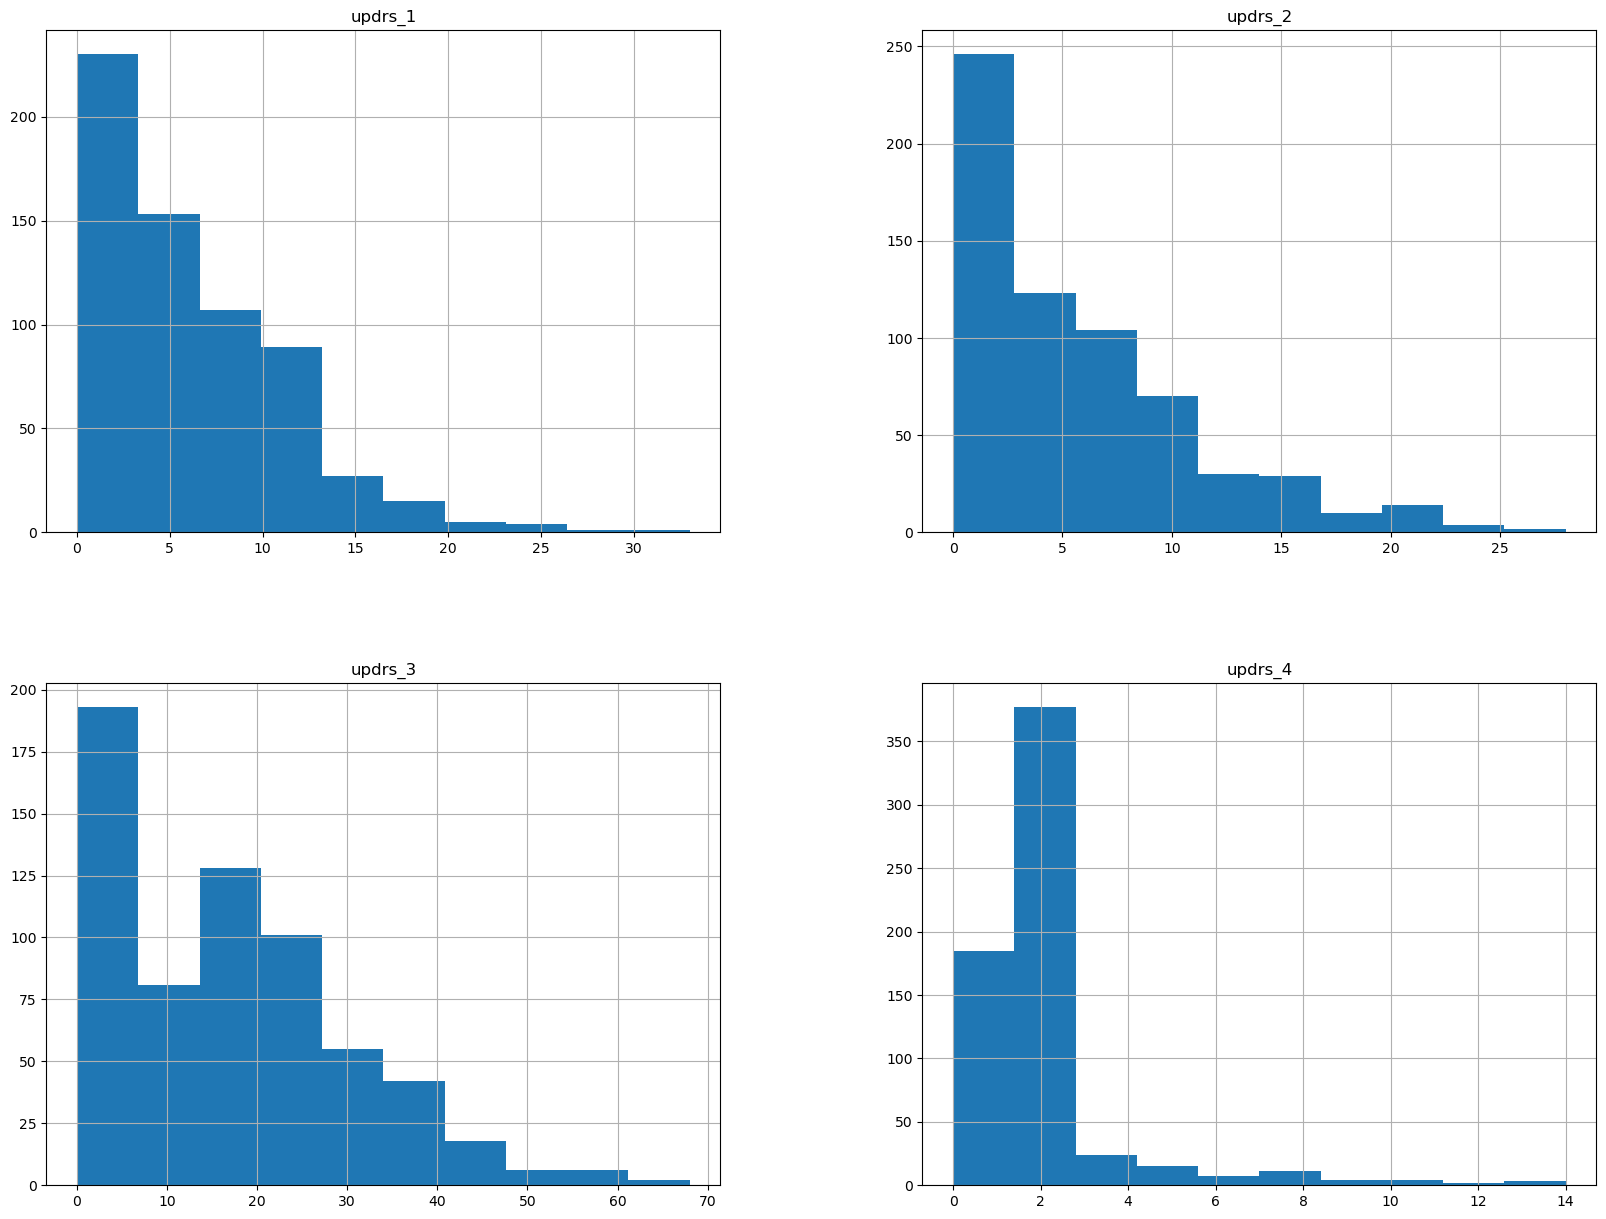

In [5]:
#full_training_data_melted[['updrs_test_score','PeptideAbundance','NPX','group_key']].corr()
full_training_data[['updrs_1','updrs_2','updrs_3','updrs_4']].hist(figsize=(20,15))

In [6]:
"""full_training_data['updrs_2_category'] = pd.cut(full_training_data['updrs_2'],
                                                          bins=[-np.inf, 15., np.inf],
                                                          labels=[1,2])

full_training_data['updrs_3_category'] = pd.cut(full_training_data['updrs_3'],
                                                          bins=[-np.inf, 20., 40., np.inf],
                                                          labels=[1,2,3])

full_training_data['updrs_4_category'] = pd.cut(full_training_data['updrs_4'],
                                                          bins=[-np.inf, 7.5, np.inf],
                                                          labels=[1,2])

full_training_data['updrs_4_category'].hist()

full_training_data['updrs_4_category'].unique()
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(full_training_data, full_training_data['updrs_4_category']):
    strat_train_set = full_training_data.loc[train_index]
    strat_test_set = full_training_data.loc[test_index]
    
print(strat_test_set['updrs_4_category'].value_counts()/len(strat_test_set))
print(strat_train_set['updrs_4_category'].value_counts()/len(strat_train_set))

"""

"full_training_data['updrs_2_category'] = pd.cut(full_training_data['updrs_2'],\n                                                          bins=[-np.inf, 15., np.inf],\n                                                          labels=[1,2])\n\nfull_training_data['updrs_3_category'] = pd.cut(full_training_data['updrs_3'],\n                                                          bins=[-np.inf, 20., 40., np.inf],\n                                                          labels=[1,2,3])\n\nfull_training_data['updrs_4_category'] = pd.cut(full_training_data['updrs_4'],\n                                                          bins=[-np.inf, 7.5, np.inf],\n                                                          labels=[1,2])\n\nfull_training_data['updrs_4_category'].hist()\n\nfull_training_data['updrs_4_category'].unique()\nsplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)\nfor train_index, test_index in split.split(full_training_data, full_training_data['updrs_

### Testing the RMSE
#### RMSE <= 0.75 : Very good accuracy | 0.75 < RMSE <= 1.0 : Good accuracy

#### First on train data (train split from the full training dataset)
#### 2nd on test data (test split from the full training dataset)

In [7]:
"""train_df_predictions = lin_reg_model_updrs_4.predict(strat_train_set_prepared)
mse = mean_squared_error(strat_train_set_labels, train_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

test_df_predictions = lin_reg_model_updrs_4.predict(strat_test_set_prepared)
mse = mean_squared_error(strat_test_set_labels, test_df_predictions)
rmse = np.sqrt(mse)
print(rmse)

model_dict['updrs_4'] = lin_reg_model_updrs_4
model_dict"""

"train_df_predictions = lin_reg_model_updrs_4.predict(strat_train_set_prepared)\nmse = mean_squared_error(strat_train_set_labels, train_df_predictions)\nrmse = np.sqrt(mse)\nprint(rmse)\n\ntest_df_predictions = lin_reg_model_updrs_4.predict(strat_test_set_prepared)\nmse = mean_squared_error(strat_test_set_labels, test_df_predictions)\nrmse = np.sqrt(mse)\nprint(rmse)\n\nmodel_dict['updrs_4'] = lin_reg_model_updrs_4\nmodel_dict"

#### The below cell is only for debugging the function get_predictions()

In [8]:
"""df_proteins = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv')
print(df_proteins.shape)

df_peptides = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv')
print(df_peptides.shape)

pro_pep_join = pd.merge(df_proteins, df_peptides, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')
del df_proteins, df_peptides
gc.collect()

full_test_data = pd.DataFrame()

for i in [0,6,12,24]:
    temp = pro_pep_join[pro_pep_join['visit_month']==i]
    full_test_data = full_test_data.append(temp)

full_test_data = full_test_data.drop(columns=['UniProt','Peptide','patient_id','group_key_x','group_key_y'])

list_of_updrs_tests = ['updrs_1','updrs_2','updrs_3','updrs_4']
    
new_features = full_test_data.groupby(['visit_id','visit_month']).agg(npx_mean=('NPX', 'mean'), npx_median=('NPX', 'median')
                                                                          , peptide_mean=('PeptideAbundance', 'mean'), peptide_median=('PeptideAbundance', 'median')
                                                          ).reset_index(level=['visit_id','visit_month'])

full_test_data = pd.merge(full_test_data, new_features, on=['visit_id','visit_month'], how='inner')
full_test_data = full_test_data.drop(columns=['NPX','PeptideAbundance'])
full_test_data = full_test_data.drop_duplicates(keep='first')
full_test_data = full_test_data[['visit_id','visit_month','npx_mean','npx_median','peptide_mean','peptide_median']]

full_test_data = full_test_data.reset_index()
full_test_data = full_test_data.drop(columns=['index'])

df_prepared = full_pipeline.transform(full_test_data)
print(df_prepared.shape)

for u in list_of_updrs_tests:
    full_test_data['result_' + str(u)] = pd.DataFrame(model_dict[u].predict(df_prepared),columns=['rating']).round(decimals=0)
    
result = pd.DataFrame()

for m in [0, 6, 12, 24]:
    for u in [1, 2, 3, 4]:
        temp = full_test_data[['visit_id', 'result_updrs_' + str(u)]]
        temp['prediction_id'] = temp['visit_id'] + '_updrs_' + str(u) + '_plus_' + str(m) + '_months'
        temp["rating"] = temp["result_updrs_" + str(u)]
        temp = temp [['prediction_id', 'rating']]

        result = result.append(temp)

result = result.drop_duplicates(subset=['prediction_id', 'rating'])

result"""

'df_proteins = pd.read_csv(\'/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv\')\nprint(df_proteins.shape)\n\ndf_peptides = pd.read_csv(\'/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv\')\nprint(df_peptides.shape)\n\npro_pep_join = pd.merge(df_proteins, df_peptides, on=[\'patient_id\',\'visit_id\',\'visit_month\',\'UniProt\'], how=\'inner\')\ndel df_proteins, df_peptides\ngc.collect()\n\nfull_test_data = pd.DataFrame()\n\nfor i in [0,6,12,24]:\n    temp = pro_pep_join[pro_pep_join[\'visit_month\']==i]\n    full_test_data = full_test_data.append(temp)\n\nfull_test_data = full_test_data.drop(columns=[\'UniProt\',\'Peptide\',\'patient_id\',\'group_key_x\',\'group_key_y\'])\n\nlist_of_updrs_tests = [\'updrs_1\',\'updrs_2\',\'updrs_3\',\'updrs_4\']\n    \nnew_features = full_test_data.groupby([\'visit_id\',\'visit_month\']).agg(npx_mean=(\'NPX\', \'mean\'), npx_median=(\'NPX\', \'median\')\n   

In [9]:
def get_predictions(df_proteins, df_peptides, model_dict, sklearn_pipeline):
    pro_pep_join = pd.merge(df_proteins, df_peptides, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')
    del df_proteins, df_peptides
    gc.collect()

    full_test_data = pd.DataFrame()

    for i in [0,6,12,24]:
        temp = pro_pep_join[pro_pep_join['visit_month']==i]
        full_test_data = full_test_data.append(temp)

    #full_test_data = full_test_data.drop(columns=['UniProt','Peptide','patient_id','group_key_x','group_key_y'])

    list_of_updrs_tests = ['updrs_1','updrs_2','updrs_3','updrs_4']

    new_features = full_test_data.groupby(['visit_id','visit_month']).agg(npx_mean=('NPX', 'mean'), npx_median=('NPX', 'median')
                                                                              , peptide_mean=('PeptideAbundance', 'mean'), peptide_median=('PeptideAbundance', 'median')
                                                              ).reset_index(level=['visit_id','visit_month'])

    full_test_data = pd.merge(full_test_data, new_features, on=['visit_id','visit_month'], how='inner')
    #full_test_data = full_test_data.drop(columns=['NPX','PeptideAbundance'])
    full_test_data = full_test_data.drop_duplicates(keep='first')
    full_test_data = full_test_data[['visit_id','visit_month','npx_mean','npx_median','peptide_mean','peptide_median']]

    full_test_data = full_test_data.reset_index()
    full_test_data = full_test_data.drop(columns=['index'])
    
    df_prepared = sklearn_pipeline.transform(full_test_data)
    print(df_prepared.shape)

    for u in list_of_updrs_tests:
        full_test_data['result_' + str(u)] = pd.DataFrame(model_dict[u].predict(df_prepared),columns=['rating']).round(decimals=0)
    
    result = pd.DataFrame()

    for m in [0, 6, 12, 24]:
        for u in [1, 2, 3, 4]:
            temp = full_test_data[['visit_id', 'result_updrs_' + str(u)]]
            temp['prediction_id'] = temp['visit_id'] + '_updrs_' + str(u) + '_plus_' + str(m) + '_months'
            temp["rating"] = temp["result_updrs_" + str(u)]
            temp = temp [['prediction_id', 'rating']]

            result = result.append(temp)

    result = result.drop_duplicates(subset=['prediction_id', 'rating'])
    
    return result

In [10]:
import amp_pd_peptide
env = amp_pd_peptide.make_env()   # initialize the environment
iter_test = env.iter_test()

for (test, test_peptides, test_proteins, submission) in iter_test:
    result = get_predictions(test_proteins, test_peptides, model_dict, full_pipeline)
    env.predict(result)
    
##result.to_csv('/kaggle/working/submission.csv', header=True, index=False)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
(1021, 8)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1036, 8)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
